In [6]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from tensorflow.keras.utils import Sequence 
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Attention

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, Reshape
from tensorflow.keras.layers import MultiHeadAttention, Dense, GlobalAveragePooling2D, Add, Activation

from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Permute, Multiply, Lambda
import tensorflow as tf



In [4]:
train_data_dir = "/kaggle/input/dronesnew/Train"
val_data_dir = "/kaggle/input/dronesnew/Val"
test_data_dir = "/kaggle/input/dronesnew/Test"

In [6]:
img_width, img_height = 256, 256
batch_size = 32
# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = validation_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2866 images belonging to 2 classes.
Found 796 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [10]:
# InceptionV3 base model
from keras.layers import Dropout
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers for binary classification
def main_model(tl_model, class1):
    m_model = tl_model.output
    m_model = GlobalAveragePooling2D()(m_model)
    
    m_model = Dense(1024, activation='relu')(m_model)
    m_model = Dense(1024, activation='relu')(m_model)

    attention_output = Reshape((1, 1024))(m_model)  # Reshape for MultiHeadAttention
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(attention_output, attention_output)
    attention_output = Reshape((1024,))(attention_output)  # Reshape back to original shape
    
    combined_output = Add()([m_model, attention_output])
    combined_output = Activation("relu")(combined_output)
    
    combined_output = Dense(512, activation='relu')(combined_output)
    combined_output = Dense(class1, activation='softmax')(combined_output)
    
    return combined_output

model = main_model(base_model,2)

In [11]:
# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=model)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_376 (Conv2D) │ (None, None,      │        864 │ input_layer_4[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_376[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_377      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_377 (Conv2D) │ (None, None,      │      9,216 │ activation_377[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_377[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_378      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_378 (Conv2D) │ (None, None,      │     18,432 │ activation_378[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_378[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_379      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, None,      │          0 │ activation_379[0… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_379 (Conv2D) │ (None, None,      │      5,120 │ max_pooling2d_16… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_379[0][0]  │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_380      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_380 (Conv2D) │ (None, None,      │    138,240 │ activation_380[0… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_380[0][0]  │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_381      │ (None, None,      │          0 │ batch_normalizat

 Total params: 27,576,098 (105.19 MB)

 Trainable params: 5,773,314 (22.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

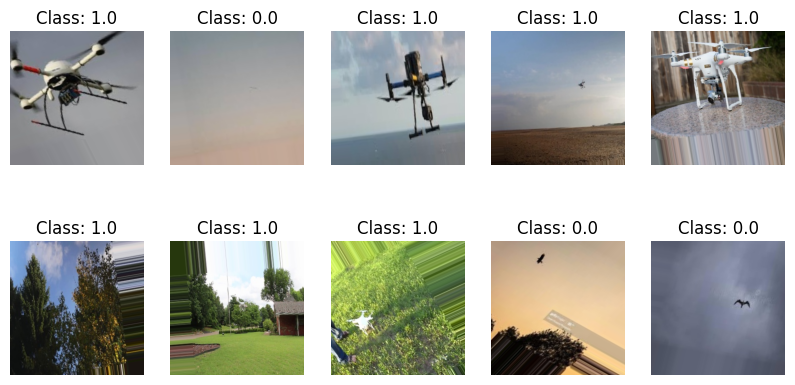

In [9]:
import matplotlib.pyplot as plt

# Get 10 samples from the generator
num_samples = 10
images, labels = next(train_generator)

# Plot the images
plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.title('Class: {}'.format(labels[i]))
    plt.axis('off')
plt.show()

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/19 ━━━━━━━━━━━━━━━━━━━━ 11:55 40s/step - accuracy: 0.3125 - loss: 0.9864

I0000 00:00:1713170779.115682     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713170779.165446     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/19 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4868 - loss: 0.9930  

W0000 00:00:1713170808.835250     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5139 - loss: 0.9683

W0000 00:00:1713170815.978060     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5175 - loss: 0.9647 - val_accuracy: 0.8594 - val_loss: 0.3184
Epoch 2/50
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6875 - loss: 0.4687

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 596ms/step - accuracy: 0.6875 - loss: 0.4687 - val_accuracy: 0.8571 - val_loss: 0.2077
Epoch 3/50


W0000 00:00:1713170827.726255      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 558ms/step - accuracy: 0.8295 - loss: 0.4389 - val_accuracy: 0.9323 - val_loss: 0.1821
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9062 - loss: 0.2779 - val_accuracy: 0.8571 - val_loss: 0.1934
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 551ms/step - accuracy: 0.8774 - loss: 0.3502 - val_accuracy: 0.9115 - val_loss: 0.1785
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9375 - loss: 0.1293 - val_accuracy: 1.0000 - val_loss: 0.0319
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 558ms/step - accuracy: 0.8800 - loss: 0.3276 - val_accuracy: 0.9427 - val_loss: 0.1769
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9062 - loss: 0.2695 - val_accuracy: 1.0000 - val_loss: 0.0295
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 558ms/step - accuracy: 0.9458 - loss: 0.1477 - val_accuracy: 0.9479 - val_loss: 0.1655
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8750 - loss: 0.2437 - val_accuracy: 0.8571 - val_los

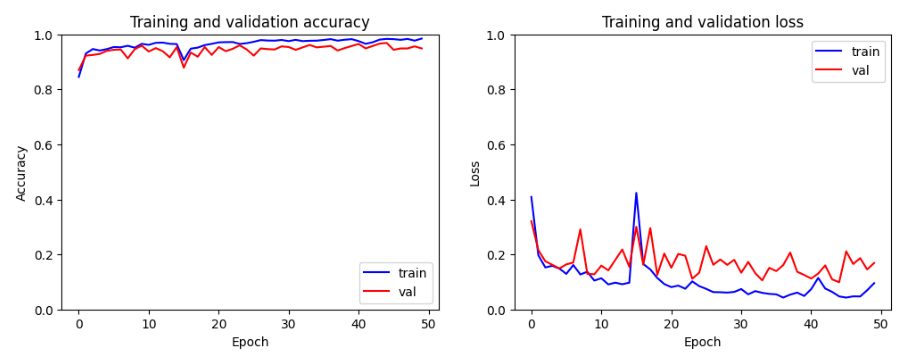

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('inception2.png')  # Replace 'your_image_path.jpg' with the path to your image file
plt.figure(figsize=(16, 12))  # Adjust the width and height as needed

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [7]:
from sklearn.metrics import classification_report

# Evaluate the model
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Make predictions
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)

# Get true labels
true_labels = test_generator.classes

# Classification report
print(classification_report(true_labels, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.92      0.96       300
           1       0.96      0.84      0.95       297

    accuracy                           0.97       597
   macro avg       0.87      0.88      0.96       597
weighted avg       0.87      0.88      0.96       597



Confusion Matrix:
[[276  24]
 [ 48 249]]


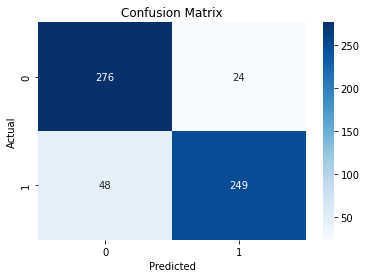

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
